# Identify what makes song motifs neurally similar vs different

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import umap
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# T_SNP = .5
# T_SNP = 1
# N_NEIGHBORS = 100
# T_SNP = 2
T_SNP = 5
N_NEIGHBORS = 100
# T_SNP = 30
# N_NEIGHBORS = 10

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
def get_snippets(T_SNP, MIN_GAP, MIN_POWER=0, MAX_POWER=1):
    # get snippets
    nt_snp = int(round(T_SNP*FPS))
    t_snp = np.arange(nt_snp)*DT

    snps = []

    # go through all songs
    for ctr, sng_full in enumerate(sngs_full):
        
        segs, bds = get_seg(sng_full > 0, min_gap=int(round(MIN_GAP/DT)))
        
        segs = [sng_full[lb:ub] for lb, ub in bds]
        
        # keep fixed-length portions only of sufficiently long segments
        segs = [
            seg[:nt_snp] for seg in segs
            if (len(seg) >= nt_snp)
            and (np.mean(seg[:nt_snp] > 0) > MIN_POWER)
            and (np.mean(seg[:nt_snp] > 0) < MAX_POWER)
        ]
        
        snps.extend(segs)

    snps = np.array(snps)
    nsnp = len(snps)

    i_ss = [(snp == 1).astype(float) for snp in snps]
    i_ps = [(snp == 2).astype(float) for snp in snps]
    
    return snps, i_ss, i_ps

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, adapt='MA'):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        if adapt == 'MA':
            vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        elif adapt == 'lin':
            vs[ct, :] = x_s*(i_s[ct]-a_ss[ct-1, :]) + x_p*(i_p[ct]-a_ps[ct-1, :])
        
        # update integral
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [6]:
def get_rs(motifs, tau_r, tau_a, x_s, x_p, adapt):
    nrl_basis = np.nan*np.zeros((len(tau_r), len(motifs)))
    rs_full = []

    for cmotif, motif in enumerate(motifs):
        i_s = (motif == 1).astype(float)
        i_p = (motif == 2).astype(float)

        tmotif = np.arange(len(motif))*DT

        rs = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, adapt=adapt)[0]

        nrl_basis[:, cmotif] = rs[-1, :]
        rs_full.append(rs)
        
    return rs_full

In [7]:
def get_alignment(r_0, r_1):
    r_0_hat = r_0/np.linalg.norm(r_0)
    r_1_hat = r_1/np.linalg.norm(r_1)
    return r_0_hat@r_1_hat

In [8]:
np.random.seed(0)

N = 20

TAU_R = np.random.uniform(120, 120, N)
TAU_A = np.random.uniform(.1, 2, N)
X_S = np.random.uniform(0, 1, N)
X_P = np.random.uniform(0, 1, N)

In [9]:
motifs, i_ss, i_ps = get_snippets(T_SNP=T_SNP, MIN_GAP=T_SNP, MIN_POWER=0.01)
r_motifs = np.array([rs_full[-1, :] for rs_full in get_rs(motifs, TAU_R, TAU_A, X_S, X_P, adapt='MA')])
print(f'{len(motifs)} motifs')

927 motifs


In [10]:
# color by sine/pulse ratio
colors = []
sizes = []
for motif in motifs:
    frac_q = np.mean(motif==0)
    frac_s = np.mean(motif==1)
    frac_p = np.mean(motif==2)
    color = frac_s*np.array([0, 0, 1]) + frac_p*np.array([1, 0, 0]) + frac_q*np.array([0, 0, 0])
    colors.append(color)
    size = np.mean(motif > 0)*100
    sizes.append(size)

In [11]:
np.random.seed(1)

reducer_2d = umap.UMAP(n_neighbors=N_NEIGHBORS, n_components=2, metric='cosine', min_dist=1)
u_2d = reducer_2d.fit_transform(r_motifs)

reducer_3d = umap.UMAP(n_neighbors=N_NEIGHBORS, n_components=3, metric='cosine', min_dist=1)
u_3d = reducer_3d.fit_transform(r_motifs)

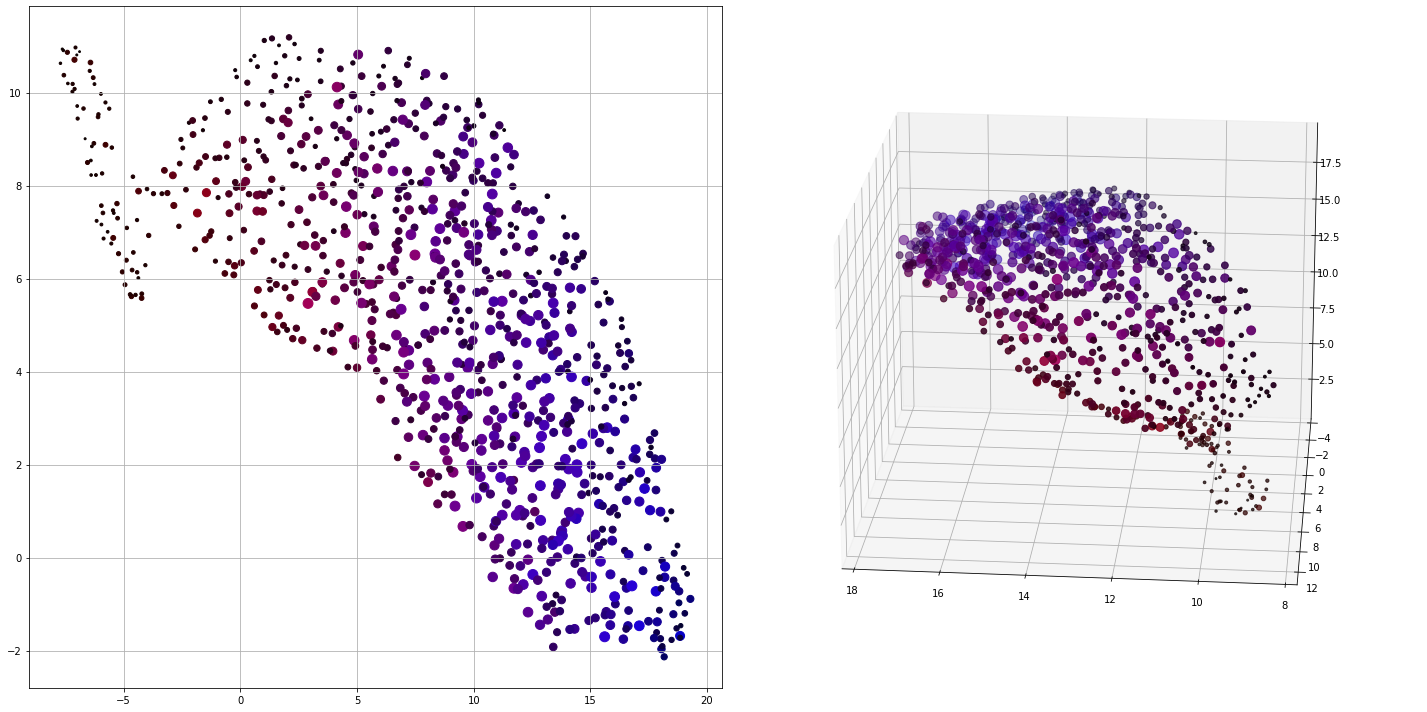

In [12]:
fig = plt.figure(figsize=(20, 10), tight_layout=True)
axs = [fig.add_subplot(121), fig.add_subplot(122, projection='3d')]
axs[0].scatter(u_2d[:, 0], u_2d[:, 1], c=colors, s=sizes)
axs[0].grid()
axs[1].scatter(u_3d[:, 0], u_3d[:, 1], u_3d[:, 2], c=colors, s=sizes)
axs[1].view_init(azim=95, elev=20)

In [13]:
def get_motifs_from_umap_2(xb, yb, u_2d):
    mx = (xb[0] <= u_2d[:, 0]) & (u_2d[:, 0] < xb[1])
    my = (yb[0] <= u_2d[:, 1]) & (u_2d[:, 1] < yb[1])
    idxs = np.nonzero(mx&my)[0]
    return [motifs[idx] for idx in idxs], idxs

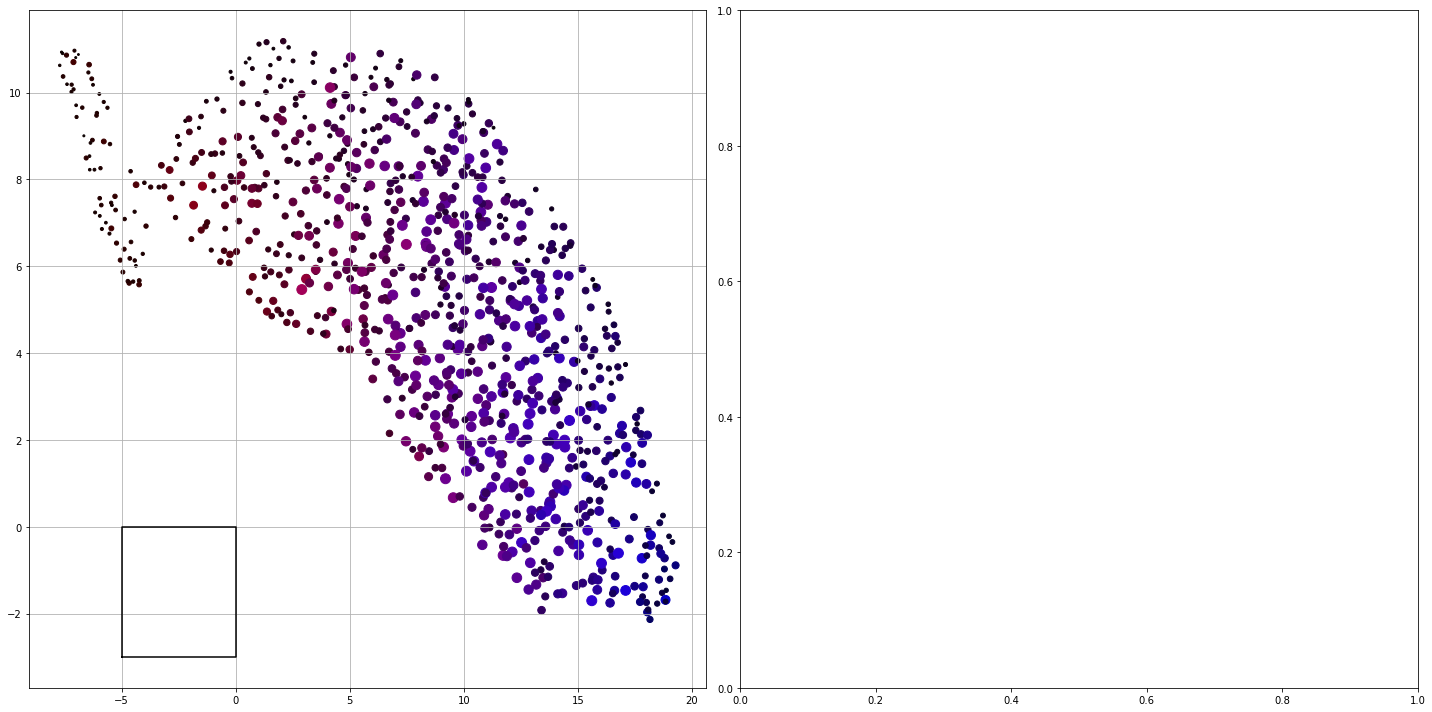

In [14]:
# xb, yb = [5, 10], [-1, 1]
# xb, yb = [5, 8], [-5, -3]
# xb, yb = [13, 16], [-9, -7]
# xb, yb = [9, 12], [-8, -5]
# xb, yb = [16, 18], [-6, -4]
# xb, yb = [21, 24], [-5, -3]

# xb, yb = [5, 10], [15, 17]

# xb, yb = [5, 10], [5, 10]

xb, yb = [-5, 0], [-3, 0]

motifs_partial = get_motifs_from_umap_2(xb, yb, u_2d)[0]

fig, axs = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
axs[0].scatter(u_2d[:, 0], u_2d[:, 1], c=colors, s=sizes)
axs[0].plot([xb[0], xb[1], xb[1], xb[0], xb[0]], [yb[0], yb[0], yb[1], yb[1], yb[0]], c='k')
axs[0].grid()

for cmotif, motif in enumerate(motifs_partial):
    t = np.arange(len(motif))*DT
    plot_b(axs[1], t, motif, extent=[0, t.max(), -cmotif, -cmotif-.8], c=('gray', 'b', 'r'))

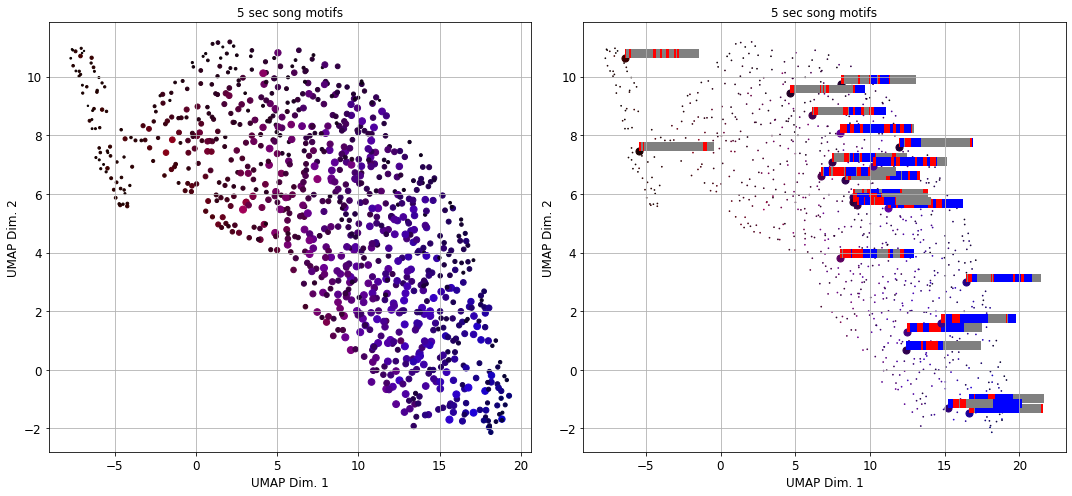

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), tight_layout=True)
axs[0].scatter(u_2d[:, 0], u_2d[:, 1], c=colors, s=.5*np.array(sizes))
axs[0].grid()

axs[1].scatter(u_2d[:, 0], u_2d[:, 1], c=colors, s=.5)
axs[1].grid()

pplot = .03

for cmotif, motif in enumerate(motifs):
    if np.random.rand() > pplot:
        continue
    
    axs[1].scatter(u_2d[cmotif, 0], u_2d[cmotif, 1], c=[colors[cmotif]], s=50)
    extent = [u_2d[cmotif, 0], u_2d[cmotif, 0]+5, u_2d[cmotif, 1], u_2d[cmotif, 1]+.3]
    
    t = np.arange(len(motif))*DT
    
    plot_b(axs[1], t, motif, extent=extent, c=('gray', 'b', 'r'))
    
for ax in axs:
    set_plot(ax, x_label='UMAP Dim. 1', y_label='UMAP Dim. 2', title=f'{T_SNP} sec song motifs')
    
fig.savefig(f'supp/16_umap_t_snp_{T_SNP}.svg')